In [329]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colormaps
import numpy as np
import geopandas as gpd
import seaborn as sns

# Population Wages

### What is the poverty line in the US?
**Source:** [Assistant Secretary for Planning and Evaluation](https://aspe.hhs.gov/topics/poverty-economic-mobility/poverty-guidelines) **Year:** 2024

In [330]:
df_pov_guid = pd.read_csv('Datasets/Poverty_Guidelines.csv')
df_pov_guid.head()

,Persons in family/household,2024 POVERTY GUIDELINES FOR THE 48 CONTIGUOUS STATES AND THE DISTRICT OF COLUMBIA,2024 POVERTY GUIDELINES FOR ALASKA,2024 POVERTY GUIDELINES FOR HAWAII
0,1,"$15,060","$18,810","$17,310"
1,2,"$20,440","$25,540","$23,500"
2,3,"$25,820","$32,270","$29,690"
3,4,"$31,200","$39,000","$35,880"
4,5,"$36,580","$45,730","$42,070"


Data Cleaning:
* Shorten column names.
* Convert data entries to numeric values.
* Add 'National_PG' column for weighted average of poverty guidelines across US.
* Select only national guidelines.

In [331]:
df_pov_guid.columns = ['Household Size', 'US_PG', 'Alaska_PG', 'Hawaii_PG']

In [332]:
df_pov_guid['US_PG'] = df_pov_guid['US_PG'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_pov_guid['Alaska_PG'] = df_pov_guid['Alaska_PG'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_pov_guid['Hawaii_PG'] = df_pov_guid['Hawaii_PG'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)

In [333]:
non_con = df_pov_guid[['Alaska_PG', 'Hawaii_PG']].sum(axis=1)
con = df_pov_guid['US_PG'] * 49
df_pov_guid['National_PG'] = (con + non_con) / 51

In [334]:
df_pov_guid = df_pov_guid.iloc[:, 0:5:4]

In [335]:
df_pov_guid.head()

,Household Size,National_PG
0,1,15177.647059
1,2,20600.000000
2,3,26022.352941
3,4,31444.705882
4,5,36867.058824


In [336]:
pov_value = df_pov_guid['National_PG'].min()

### What is the minimum wage across the US?
**Source:** [US Department of Labor](https://www.dol.gov/agencies/whd/state/minimum-wage/history) **Year:** 2023

In [337]:
df_min_wage = pd.read_csv('Datasets/Minimum_Wage.csv')
df_min_wage.head()

,State or other\njurisdiction,2020,2021,2022,2023
0,Federal (FLSA),7.25,7.25,7.25,7.25
1,Alabama,...,...,...,...
2,Alaska,10.19,10.34,10.34,10.85
3,Arizona,12,12.15,12.8,13.85
4,Arkansas,10.00[c],11,11,11


Data Cleaning:
* Use 'State' as umbrella term to include US Territories.
* Change national minimum wage to 'NATIONAL.'
* Select only data from 2023.
* Remove codes from the 2023 columns (i.e. numberic values only).
* Create column of annual salary for a 40 hour work week.

In [338]:
df_min_wage = df_min_wage.rename(columns={'State or other\njurisdiction': 'State'})

In [339]:
df_min_wage = df_min_wage.replace('Federal (FLSA)', 'NATIONAL')

In [340]:
df_min_wage = df_min_wage.iloc[:, 0:5:4]

In [341]:
df_min_wage['2023'] = df_min_wage['2023'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

In [342]:
df_min_wage['Annual Salary'] = df_min_wage['2023'] * 40 * 52

In [343]:
df_min_wage.head()

,State,2023,Annual Salary
0,NATIONAL,7.25,15080.0
1,Alabama,NaN,NaN
2,Alaska,10.85,22568.0
3,Arizona,13.85,28808.0
4,Arkansas,11.00,22880.0


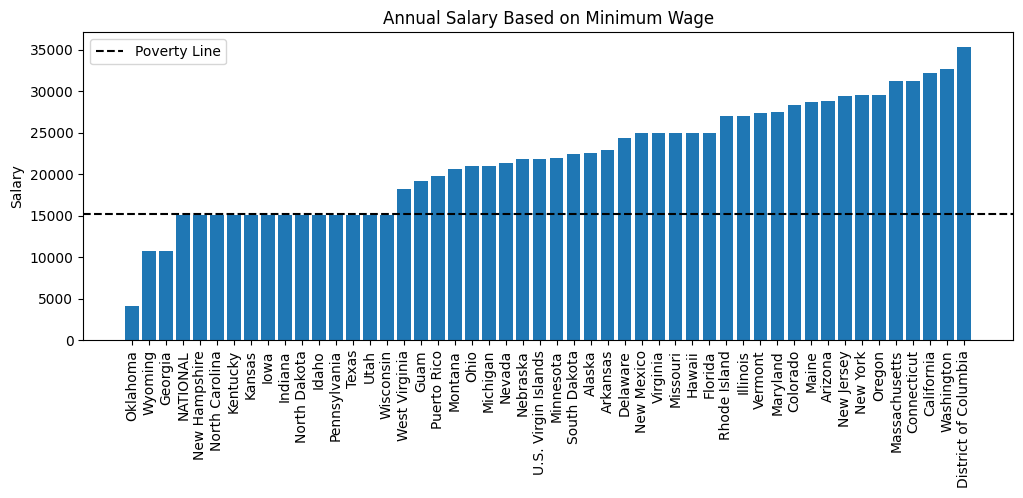

In [344]:
df_min_wage_ORD = df_min_wage.sort_values(by='Annual Salary').dropna()
plt.figure(figsize=(12, 4))
plt.bar(df_min_wage_ORD['State'], df_min_wage_ORD['Annual Salary'])
plt.axhline(pov_value, color='black',linestyle='--', label=f'Poverty Line')
plt.ylabel('Salary')
plt.title('Annual Salary Based on Minimum Wage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### What is the living wage across the US?
*Note: Median living wage is also avaiable.*

**Source:** [Economic Policy Institute](https://files.epi.org/uploads/fbc_livingwage_data_2024.xlsx) **Year:** 2024

In [345]:
df_liv_wage = pd.read_csv('Datasets/Living_Wage.csv')
df_liv_wage.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Summary statistics (across columns),Unnamed: 4,Unnamed: 5,"One adult, no children",Unnamed: 7,Unnamed: 8,"One adult, one child",...,Unnamed: 15,Unnamed: 16,"Two workers, one full-time, one part-time",Unnamed: 18,Unnamed: 19,Unnamed: 20,Two full-time workers,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,state_alpha,Name,Measure*,Min,Median,Max,All income from wages,81% of income from wages (CBO est.),Employer provided healthcare,All income from wages,...,Employer provided healthcare,Child care capped at 7% of income,All income from wages,81% of income from wages (CBO est.),Employer provided healthcare,Child care capped at 7% of income,All income from wages,81% of income from wages (CBO est.),Employer provided healthcare,Child care capped at 7% of income
1,AL,Alabama,Standard that insures living wage for entire s...,$19.69,$29.80,$51.72,$24.31,$19.69,$21.86,$36.79,...,$44.38,$47.16,$34.48,$27.93,$29.59,$31.44,$25.86,$20.94,$22.19,$23.58
2,AL,Alabama,Median state living wage,$16.43,$24.79,$43.83,$20.29,$16.43,$18.07,$30.04,...,$37.19,$40.41,$29.22,$23.67,$24.79,$26.94,$21.92,$17.75,$18.59,$20.20
3,AK,Alaska,Standard that insures living wage for entire s...,$22.70,$35.40,$61.70,$28.02,$22.70,$24.91,$43.70,...,$51.73,$57.44,$41.14,$33.32,$34.49,$38.29,$30.85,$24.99,$25.87,$28.72
4,AK,Alaska,Median state living wage,$19.16,$32.48,$56.83,$23.66,$19.16,$20.99,$38.17,...,$48.71,$49.09,$37.89,$30.69,$32.48,$32.73,$28.41,$23.02,$24.36,$24.54


Data Cleaning:
* Remove columm of state abbreviations.
* Reduce rows to include the 'standard' values.
* Reduce columns to include 'all income from wages' values.
* Combine information from first two rows.
* Use only data from one adult, no children.
* Convert data to numeric values.
* Create column with annual salary for a 40 hour work week.

In [346]:
df_liv_wage = df_liv_wage.iloc[:, 1:]

In [347]:
df_liv_wage = df_liv_wage[~df_liv_wage['Unnamed: 2'].str.contains('Median', na=False)]

In [348]:
df_liv_wage = df_liv_wage.rename(columns={'Unnamed: 1': 'State'})
df_liv_wage.drop(df_liv_wage.columns[df_liv_wage.columns.str.contains('Unnamed|Summary')], axis=1, inplace=True)

In [349]:
df_liv_wage = df_liv_wage[1:]

In [350]:
df_liv_wage = df_liv_wage.iloc[:, :2]

In [351]:
df_liv_wage['One adult, no children'] = df_liv_wage['One adult, no children'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

In [352]:
df_liv_wage['Annual Salary'] = df_liv_wage['One adult, no children'] * 40 * 52

In [353]:
df_liv_wage = df_liv_wage.reset_index(drop=True)
df_liv_wage.head()

,State,"One adult, no children",Annual Salary
0,Alabama,24.31,50564.8
1,Alaska,28.02,58281.6
2,Arizona,26.18,54454.4
3,Arkansas,21.21,44116.8
4,California,40.51,84260.8


In [354]:
df_combined = pd.merge(df_min_wage, df_liv_wage, left_on='State', right_on='State')
df_combined.columns = ['State', 'Min Wage', 'MW Salary', 'Liv Wage', 'LW Salary']
df_combined.drop(df_combined.columns[~df_combined.columns.str.contains('Salary|State')], axis=1, inplace=True)
df_combined.head()

,State,MW Salary,LW Salary
0,Alabama,NaN,50564.8
1,Alaska,22568.0,58281.6
2,Arizona,28808.0,54454.4
3,Arkansas,22880.0,44116.8
4,California,32240.0,84260.8


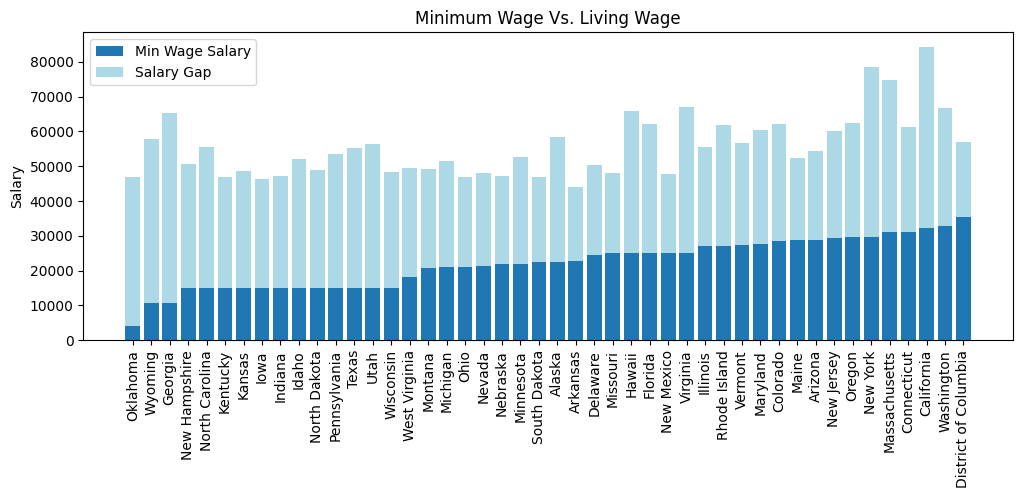

In [355]:
df_combined_ORD = df_combined.sort_values(by='MW Salary').dropna()
df_combined_ORD['LW - MW'] = df_combined['LW Salary'] - df_combined['MW Salary']
plt.figure(figsize=(12, 4))
plt.bar(df_combined_ORD['State'], df_combined_ORD['MW Salary'], label='Min Wage Salary')
plt.bar(df_combined_ORD['State'], df_combined_ORD['LW - MW'], bottom=df_combined_ORD['MW Salary'], color='lightblue', label='Salary Gap')
plt.ylabel('Salary')
plt.title('Minimum Wage Vs. Living Wage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### What is the average (and median) income across the US?
**Source:** [US Census Bureau](https://data.census.gov/table/ACSST1Y2022.S1901?t=Income%20and%20Poverty&g=010XX00US,$0400000) **Year:** 2022

In [356]:
df_salaries = pd.read_csv('Datasets/Average_Income.csv')
df_salaries.head()

,Label (Grouping),United States!!Households!!Estimate,United States!!Households!!Margin of Error,United States!!Families!!Estimate,United States!!Families!!Margin of Error,United States!!Married-couple families!!Estimate,United States!!Married-couple families!!Margin of Error,United States!!Nonfamily households!!Estimate,United States!!Nonfamily households!!Margin of Error,Alabama!!Households!!Estimate,...,Wyoming!!Nonfamily households!!Estimate,Wyoming!!Nonfamily households!!Margin of Error,Puerto Rico!!Households!!Estimate,Puerto Rico!!Households!!Margin of Error,Puerto Rico!!Families!!Estimate,Puerto Rico!!Families!!Margin of Error,Puerto Rico!!Married-couple families!!Estimate,Puerto Rico!!Married-couple families!!Margin of Error,Puerto Rico!!Nonfamily households!!Estimate,Puerto Rico!!Nonfamily households!!Margin of Error
0,Total,"129,870,928","±136,261","83,304,153","±133,863","60,921,873","±168,299","46,566,775","±117,191","2,016,448",...,"89,956","±4,423","1,289,311","±9,077","820,788","±12,139","449,853","±9,197","468,523","±9,435"
1,"Less than $10,000",5.5%,±0.1,3.4%,±0.1,1.5%,±0.1,10.2%,±0.1,7.6%,...,9.6%,±1.7,22.4%,±0.6,16.7%,±0.8,7.7%,±0.7,35.1%,±1.2
2,"$10,000 to $14,999",3.7%,±0.1,1.8%,±0.1,0.9%,±0.1,7.4%,±0.1,5.2%,...,6.9%,±1.4,10.8%,±0.5,8.9%,±0.6,7.4%,±0.7,14.9%,±0.9
3,"$15,000 to $24,999",6.8%,±0.1,4.4%,±0.1,2.6%,±0.1,11.7%,±0.1,9.3%,...,13.3%,±1.9,18.2%,±0.6,18.1%,±0.8,16.0%,±0.9,19.8%,±0.9
4,"$25,000 to $34,999",7.3%,±0.1,5.6%,±0.1,3.8%,±0.1,10.9%,±0.1,8.6%,...,12.7%,±1.8,12.5%,±0.5,13.6%,±0.7,13.4%,±0.9,10.6%,±0.8


Data Cleaning:
* Reduce columns to include only 'non-family' households, exlude margin of error columns.
* Reduce rows to include income brackets, median, and mean.
* Transpose data set.
* Name first column 'State,' median salary to 'Median Salary,' and mean salary to 'Average Salary.'
* Rename values in 'State' column to just the state.
* Rename 'United States' value to 'NATIONAL.'
* Convert data in 'Median Salary' and 'Average Salary' to numeric values.

In [357]:
df_salaries.drop(df_salaries.columns[~df_salaries.columns.str.contains('Nonfamily households!!Estimate|Label')], axis=1, inplace=True)

In [358]:
df_salaries = df_salaries[df_salaries['Label (Grouping)'].str.contains('Mean|Median', na=False)]

In [359]:
df_salaries = df_salaries.set_index('Label (Grouping)').T.reset_index().rename_axis(None, axis=1)

In [360]:
df_salaries = df_salaries.rename(columns={'index': 'State', 'Median income (dollars)': 'Median Salary', 'Mean income (dollars)': 'Average Salary'})

In [361]:
df_salaries['State'] = df_salaries['State'].str.replace('!!Nonfamily households!!Estimate', '', regex=True)

In [362]:
df_salaries = df_salaries.replace('United States', 'NATIONAL')

In [363]:
df_salaries['Average Salary'] = df_salaries['Average Salary'].str.replace(',', '', regex=True).astype(float)
df_salaries['Median Salary'] = df_salaries['Median Salary'].str.replace(',', '', regex=True).astype(float)

In [364]:
df_salaries.head()

,State,Median Salary,Average Salary
0,NATIONAL,45046.0,66351.0
1,Alabama,32330.0,47145.0
2,Alaska,57657.0,74242.0
3,Arizona,47840.0,66724.0
4,Arkansas,31230.0,45384.0


In [365]:
df_combined = pd.merge(df_combined, df_salaries, left_on='State', right_on='State')
df_combined.head()

,State,MW Salary,LW Salary,Median Salary,Average Salary
0,Alabama,NaN,50564.8,32330.0,47145.0
1,Alaska,22568.0,58281.6,57657.0,74242.0
2,Arizona,28808.0,54454.4,47840.0,66724.0
3,Arkansas,22880.0,44116.8,31230.0,45384.0
4,California,32240.0,84260.8,59348.0,89374.0


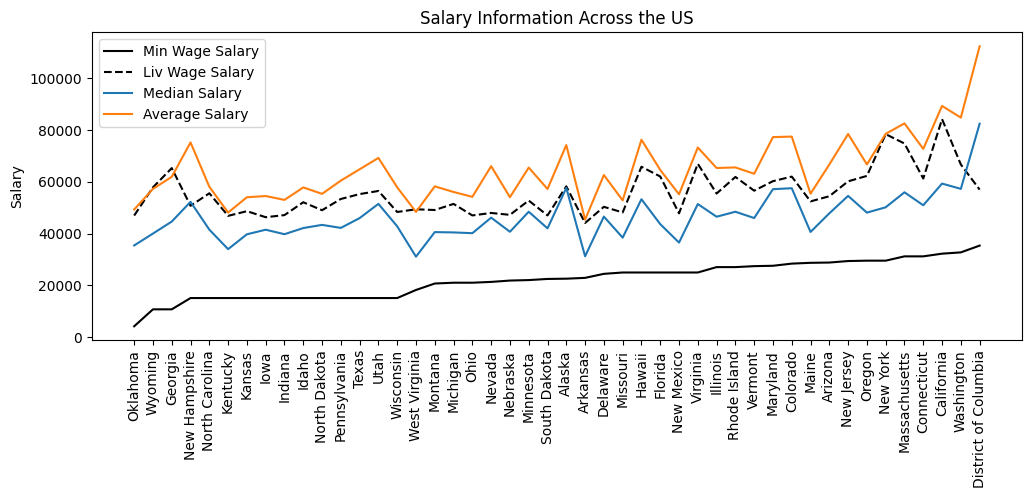

In [366]:
df_combined_ORD = df_combined.sort_values(by='MW Salary').dropna()
plt.figure(figsize=(12, 4))
plt.plot(df_combined_ORD['State'], df_combined_ORD['MW Salary'], color='black', label='Min Wage Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['LW Salary'], color='black', linestyle='--', label='Liv Wage Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Median Salary'], label='Median Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Average Salary'], label='Average Salary')
plt.ylabel('Salary')
plt.title('Salary Information Across the US')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Teacher Wages

### What is the starting salary for teachers across the US?
**Source:** [National Education Association](https://www.nea.org/resource-library/educator-pay-and-student-spending-how-does-your-state-rank/starting-teacher) **Year:** FY 2022 - 2023

In [367]:
df_star_sal = pd.read_csv('Datasets/Starting_Salary.csv')
df_star_sal.head()

,STATE,STARTING SALARY,TOP BACHELOR'S,STARTING MASTER'S,TOP MASTER'S,TOP SALARY
0,Alabama,"$43,679","$66,886","$50,164","$76,866","$88,773"
1,Alaska,"$51,207","$66,714","$56,825","$81,273","$92,052"
2,Arizona,"$44,124","$58,130","$46,721","$66,654","$73,875"
3,Arkansas,"$37,907","$50,551","$42,156",NaN,"$56,426"
4,California,"$55,283",NaN,NaN,NaN,"$109,618"


Data Cleaning:
* Select data from starting salary and top salary columns.
* Convert data to numeric values.
* Rename columns in title case.
* Rename 'Dist. of Columbia' to 'District of Columbia.'
* Rename 'United States' to 'NATIONAL.'
* Remove '*' code from Texas.

In [368]:
df_star_sal.drop(df_star_sal.columns[df_star_sal.columns.str.contains("'S")], axis=1, inplace=True)

In [369]:
df_star_sal['STARTING SALARY'] = df_star_sal['STARTING SALARY'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_star_sal['TOP SALARY'] = df_star_sal['TOP SALARY'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)

In [370]:
df_star_sal.columns = ['State', 'Starting Salary', 'Top Salary']

In [371]:
df_star_sal = df_star_sal.replace('United States', 'NATIONAL')
df_star_sal = df_star_sal.replace('Dist. of Columbia', 'District of Columbia')
df_star_sal = df_star_sal.replace('Texas*', 'Texas')

In [372]:
df_star_sal.head()

,State,Starting Salary,Top Salary
0,Alabama,43679.0,88773.0
1,Alaska,51207.0,92052.0
2,Arizona,44124.0,73875.0
3,Arkansas,37907.0,56426.0
4,California,55283.0,109618.0


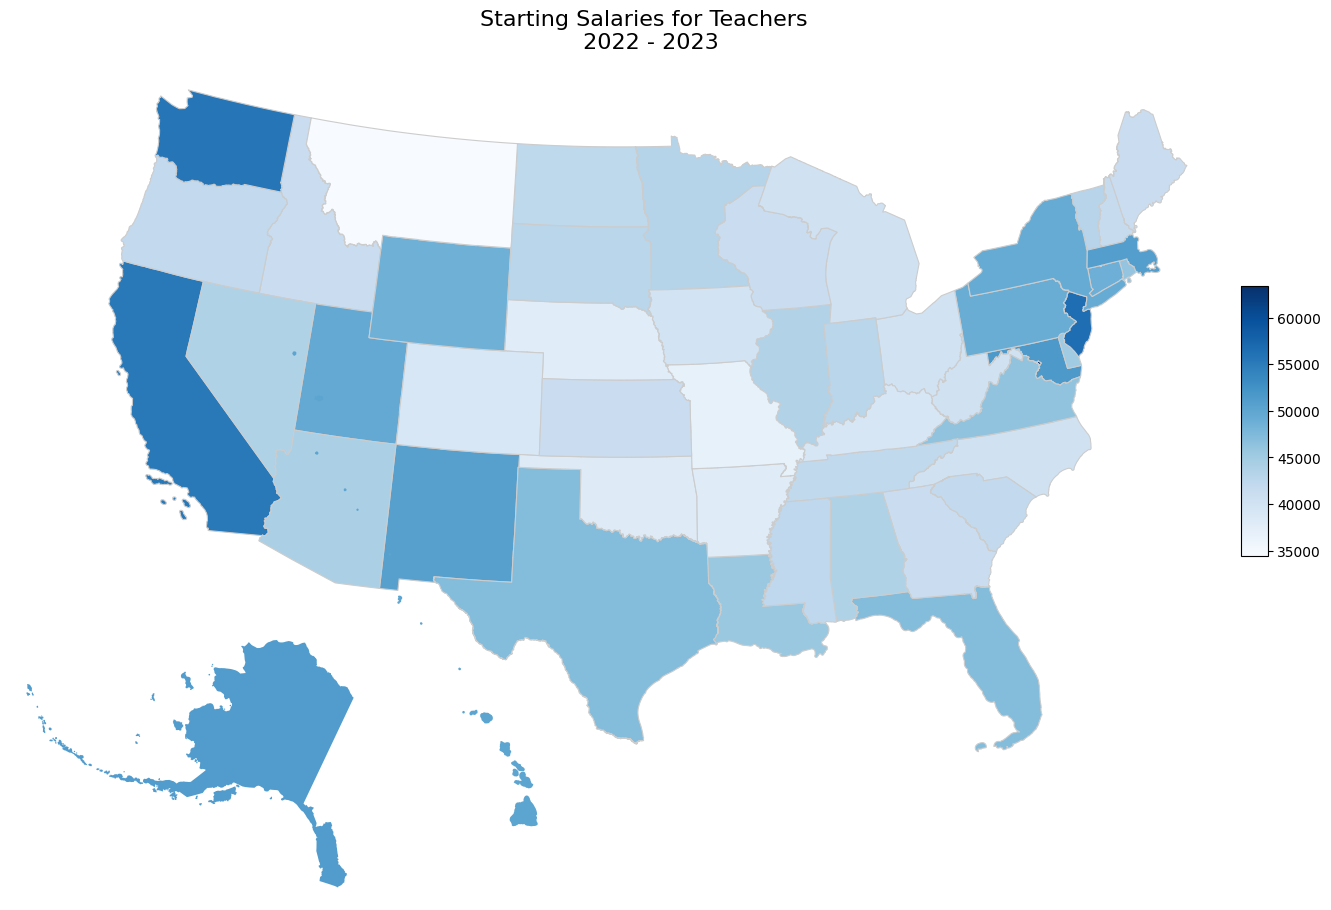

In [373]:
states = gpd.read_file('tl_2023_us_state/tl_2023_us_state.shp')
states = states.to_crs('EPSG:2267')
states = states.merge(df_star_sal, left_on='NAME', right_on='State')

alaska = states[states['NAME'] == 'Alaska']
hawaii = states[states['NAME'] == 'Hawaii']
mainland = states[(states['NAME'] != 'Alaska') & (states['NAME'] != 'Hawaii')]

vmin = states['Starting Salary'].min()
vmax = states['Starting Salary'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = colormaps['Blues']

fig, ax_main = plt.subplots(1, 1, figsize=(18, 14))
ax_alaska = fig.add_axes([0.1, 0.15, 0.2, 0.2])  # [left, bottom, width, height]
ax_hawaii = fig.add_axes([0.25, 0.15, 0.15, 0.45])

mainland.plot(ax=ax_main, column='Starting Salary', cmap=cmap, norm=norm, legend=True, 
    legend_kwds={'shrink': 0.25, 'pad': 0, 'aspect': 10}, linewidth=0.8, edgecolor='0.8')
alaska.plot(ax=ax_alaska, column='Starting Salary', cmap=cmap, norm=norm, legend=False)
hawaii.plot(ax=ax_hawaii, column='Starting Salary', cmap=cmap, norm=norm, legend=False)

ax_main.set_axis_off()
ax_alaska.set_axis_off()
ax_hawaii.set_axis_off()

ax_main.set_title('Starting Salaries for Teachers \n 2022 - 2023', fontsize=16)
plt.show()

In [374]:
df_combined = pd.merge(df_combined, df_star_sal, left_on='State', right_on='State')

### What is the average salary for teachers across the US?
**Source:** [National Education Association](https://www.nea.org/resource-library/educator-pay-and-student-spending-how-does-your-state-rank/teacher) **Year:** 2022 - 2023

In [375]:
df_avg_sal = pd.read_csv('Datasets/Average_Salary.csv')
df_avg_sal.head()

,STATE,SALARY 2021-22,RANK 2021-22,SALARY 2022-23,RANK 2022-23,2021-22 TO 2022-23 PERCENT CHANGE,2021-22 TO 2022-23 CHANGE RANK
0,Alabama,"$55,882",34,"$60,441",31,8.20%,3
1,Alaska,"$74,167",10,"$76,371",10,3.00%,33
2,Arizona,"$56,775",32,"$60,275",32,6.20%,8
3,Arkansas,"$52,610",45,"$54,309",45,3.20%,24
4,California,"$88,508",3,"$95,160",1,7.50%,4


Data Cleaning:
* Remove rank (and percent) columns.
* Rename columns to be title case and only years when applicable
* Convert data to numeric values.

In [376]:
df_avg_sal.drop(df_avg_sal.columns[df_avg_sal.columns.str.contains('RANK|PERCENT')], axis=1, inplace=True)

In [377]:
df_avg_sal.columns = ['State', '2021 - 2022', '2022 - 2023']

In [378]:
df_avg_sal['2021 - 2022'] = df_avg_sal['2021 - 2022'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)
df_avg_sal['2022 - 2023'] = df_avg_sal['2022 - 2023'].str.extract(r'(\d+\,\d+)').replace(',', '', regex=True).astype(float)

In [379]:
df_avg_sal.head()

,State,2021 - 2022,2022 - 2023
0,Alabama,55882.0,60441.0
1,Alaska,74167.0,76371.0
2,Arizona,56775.0,60275.0
3,Arkansas,52610.0,54309.0
4,California,88508.0,95160.0


In [380]:
df_combined = pd.merge(df_combined, df_avg_sal, left_on='State', right_on='State')
df_combined.columns = ['State', 'MW Salary 24', 'LW Salary 24', 'Med Salary 22', 'Avg Salary 22', 'Start Salary 22-23 (T)', 'Top Salary 22-23 (T)', 'Avg Salary 21-22 (T)', 'Avg Salary 22-23 (T)']
df_combined.head()

,State,MW Salary 24,LW Salary 24,Med Salary 22,Avg Salary 22,Start Salary 22-23 (T),Top Salary 22-23 (T),Avg Salary 21-22 (T),Avg Salary 22-23 (T)
0,Alabama,NaN,50564.8,32330.0,47145.0,43679.0,88773.0,55882.0,60441.0
1,Alaska,22568.0,58281.6,57657.0,74242.0,51207.0,92052.0,74167.0,76371.0
2,Arizona,28808.0,54454.4,47840.0,66724.0,44124.0,73875.0,56775.0,60275.0
3,Arkansas,22880.0,44116.8,31230.0,45384.0,37907.0,56426.0,52610.0,54309.0
4,California,32240.0,84260.8,59348.0,89374.0,55283.0,109618.0,88508.0,95160.0


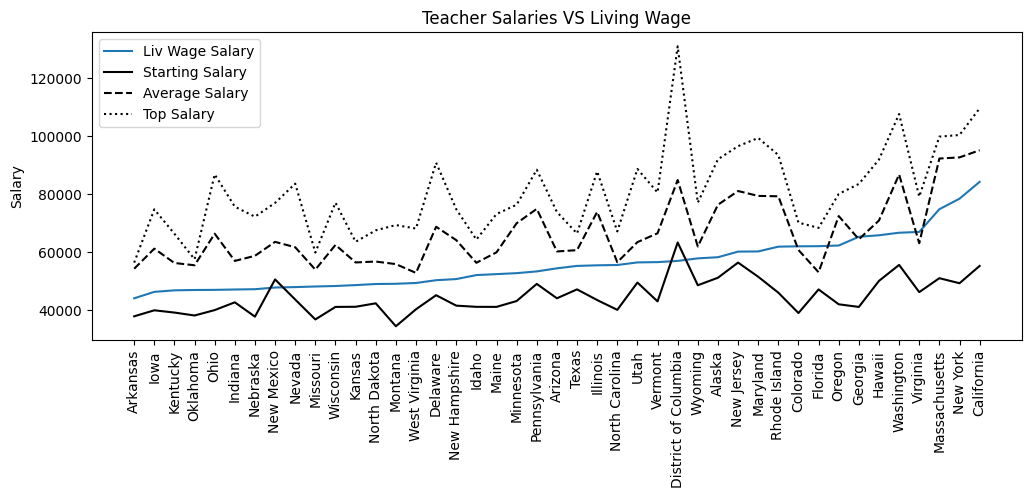

In [381]:
df_combined_ORD = df_combined.sort_values(by='LW Salary 24').dropna()
plt.figure(figsize=(12, 4))
plt.plot(df_combined_ORD['State'], df_combined_ORD['LW Salary 24'], label='Liv Wage Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Start Salary 22-23 (T)'], color='black', label='Starting Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Avg Salary 22-23 (T)'], color='black', linestyle='dashed', label='Average Salary')
plt.plot(df_combined_ORD['State'], df_combined_ORD['Top Salary 22-23 (T)'], color='black', linestyle='dotted', label='Top Salary')
plt.ylabel('Salary')
plt.title('Teacher Salaries VS Living Wage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

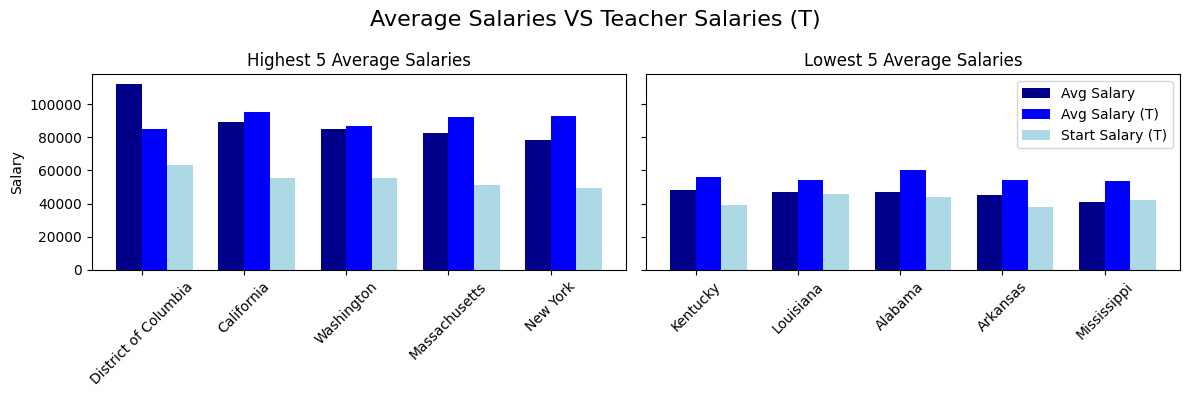

In [382]:
top_5_comb = df_combined.sort_values(by='Avg Salary 22').nlargest(5, 'Avg Salary 22')
bottom_5_comb = df_combined.sort_values(by='Avg Salary 22').nsmallest(5, 'Avg Salary 22').sort_values(by='Avg Salary 22', ascending=False)

barWidth = 0.25

r1 = np.arange(len(top_5_comb['State']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True) 

axs[0].bar(r1, top_5_comb['Avg Salary 22'], color='darkblue', width=barWidth, label='Avg Salary')
axs[0].bar(r2, top_5_comb['Avg Salary 22-23 (T)'], color='blue', width=barWidth, label='Avg Salary (T)')
axs[0].bar(r3, top_5_comb['Start Salary 22-23 (T)'], color='lightblue', width=barWidth, label='Start Salary (T)')
axs[0].set_title('Highest 5 Average Salaries')
# axs[0].set_xlabel('State')
axs[0].set_ylabel('Salary')
axs[0].set_xticks([r + barWidth / 2 for r in range(len(top_5_comb['State']))], top_5_comb['State'], rotation=45)
# axs[0].legend()

axs[1].bar(r1, bottom_5_comb['Avg Salary 22'], color='darkblue', width=barWidth, label='Avg Salary')
axs[1].bar(r2, bottom_5_comb['Avg Salary 22-23 (T)'], color='blue', width=barWidth, label='Avg Salary (T)')
axs[1].bar(r3, bottom_5_comb['Start Salary 22-23 (T)'], color='lightblue', width=barWidth, label='Start Salary (T)')
axs[1].set_title('Lowest 5 Average Salaries')
# axs[1].set_xlabel('State')
# axs[1].set_ylabel('Salary')
axs[1].set_xticks([r + barWidth / 2 for r in range(len(bottom_5_comb['State']))], bottom_5_comb['State'], rotation=45)
axs[1].legend()

fig.suptitle('Average Salaries VS Teacher Salaries (T)', fontsize=16)

plt.tight_layout()

plt.show()

# School Enrollment

### What is the school enrollment rate across the US?
**Source:** [United States Census Bureau](https://data.census.gov/table/ACSST1Y2022.S1401?t=Education&g=010XX00US,$0400000) **Year:** 2022

In [383]:
df_enroll = pd.read_csv('Datasets/School_Enrollment.csv')
df_enroll.head(5)

,Label (Grouping),United States!!Total!!Estimate,United States!!Total!!Margin of Error,United States!!Percent!!Estimate,United States!!Percent!!Margin of Error,United States!!In public school!!Estimate,United States!!In public school!!Margin of Error,United States!!Percent in public school!!Estimate,United States!!Percent in public school!!Margin of Error,United States!!In private school!!Estimate,...,Puerto Rico!!Percent!!Estimate,Puerto Rico!!Percent!!Margin of Error,Puerto Rico!!In public school!!Estimate,Puerto Rico!!In public school!!Margin of Error,Puerto Rico!!Percent in public school!!Estimate,Puerto Rico!!Percent in public school!!Margin of Error,Puerto Rico!!In private school!!Estimate,Puerto Rico!!In private school!!Margin of Error,Puerto Rico!!Percent in private school!!Estimate,Puerto Rico!!Percent in private school!!Margin of Error
0,Population 3 years and over enrolled in school,"79,389,309","±102,478",(X),(X),(X),(X),82.1%,±0.1,(X),...,(X),(X),(X),(X),61.4%,±1.3,(X),(X),38.6%,±1.3
1,"Nursery school, preschool","4,581,053","±37,570",5.8%,±0.1,"2,674,656","±33,229",58.4%,±0.5,"1,906,397",...,4.6%,±0.5,"21,342","±2,723",68.4%,±5.0,"9,841","±1,939",31.6%,±5.0
2,Kindergarten to 12th grade,"53,672,724","±53,692",67.6%,±0.1,"46,977,973","±80,965",87.5%,±0.1,"6,694,751",...,62.5%,±0.8,"305,038","±7,241",72.6%,±1.6,"115,128","±6,720",27.4%,±1.6
3,Kindergarten,"3,995,875","±37,442",5.0%,±0.1,"3,404,754","±35,331",85.2%,±0.3,"591,121",...,3.5%,±0.4,"15,349","±2,204",65.4%,±5.6,"8,108","±1,667",34.6%,±5.6
4,Elementary: grade 1 to grade 4,"15,705,251","±51,854",19.8%,±0.1,"13,603,795","±55,436",86.6%,±0.2,"2,101,456",...,16.4%,±0.7,"76,339","±4,875",69.3%,±2.8,"33,790","±3,293",30.7%,±2.8


Data Cleaning:
* Select rows that are '... year olds enrolled in school'
* Keep columms '... Percent!!Estimate'
* Transpose columns and rows.
* Shorten all column names.
* Reduce state data to include only the state.
* Change 'United States' to 'NATIONAL.'
* Change data to numeric.

In [384]:
df_enroll = df_enroll[df_enroll['Label (Grouping)'].str.contains('year olds enrolled in school', na=False)]

In [385]:
df_enroll.drop(df_enroll.columns[~df_enroll.columns.str.contains('Percent!!Estimate|Label')], axis=1, inplace=True)

In [386]:
df_enroll = df_enroll.set_index('Label (Grouping)').T.reset_index().rename_axis(None, axis=1)

In [387]:
df_enroll.columns = ['State', 'Ages: 3-4', 'Ages: 5-9', 'Ages: 10-14', 'Ages: 15-17', 'Ages: 18-19', 'Ages: 20-24', 'Ages: 25-34']

In [388]:
df_enroll['State'] = df_enroll['State'].str.replace('!!Percent!!Estimate', '', regex=True)

In [389]:
df_enroll = df_enroll.replace('United States', 'NATIONAL')

In [390]:
df_enroll['Ages: 3-4'] = df_enroll['Ages: 3-4'].str.replace('%', '', regex=True).astype(float)
df_enroll['Ages: 5-9'] = df_enroll['Ages: 5-9'].str.replace('%', '', regex=True).astype(float)
df_enroll['Ages: 10-14'] = df_enroll['Ages: 10-14'].str.replace('%', '', regex=True).astype(float)
df_enroll['Ages: 15-17'] = df_enroll['Ages: 15-17'].str.replace('%', '', regex=True).astype(float)
df_enroll['Ages: 18-19'] = df_enroll['Ages: 18-19'].str.replace('%', '', regex=True).astype(float)
df_enroll['Ages: 20-24'] = df_enroll['Ages: 20-24'].str.replace('%', '', regex=True).astype(float)
df_enroll['Ages: 25-34'] = df_enroll['Ages: 25-34'].str.replace('%', '', regex=True).astype(float)

In [391]:
df_enroll.head()

,State,Ages: 3-4,Ages: 5-9,Ages: 10-14,Ages: 15-17,Ages: 18-19,Ages: 20-24,Ages: 25-34
0,NATIONAL,46.7,94.4,97.8,96.6,72.1,38.2,10.5
1,Alabama,43.8,94.0,98.2,95.8,76.1,39.5,10.1
2,Alaska,41.9,94.3,97.9,97.5,47.2,19.5,8.9
3,Arizona,33.7,92.2,98.1,96.2,66.6,34.9,11.5
4,Arkansas,45.2,89.1,96.2,94.2,65.6,31.9,8.3


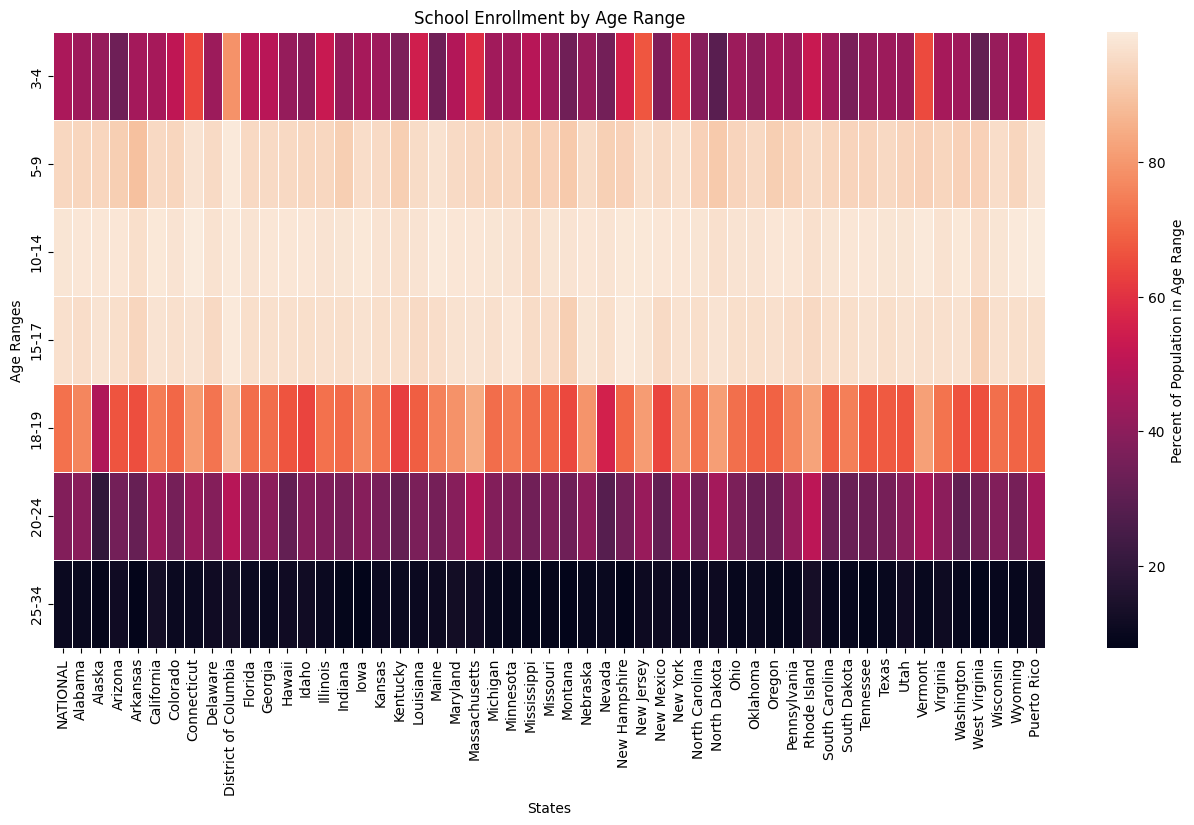

In [392]:
df_heatmap = df_enroll
df_heatmap.columns = ['State', '3-4', '5-9', '10-14', '15-17', '18-19', '20-24', '25-34']
df_heatmap.set_index('State', inplace=True)
df_heatmap = df_heatmap.T
plt.figure(figsize=(16, 8))
sns.heatmap(df_heatmap, annot=False, cbar_kws={'label': 'Percent of Population in Age Range'}, linewidths=0.5, linecolor='white')
plt.title('School Enrollment by Age Range')
plt.xlabel('States')
plt.ylabel('Age Ranges')
plt.xticks(rotation=90)
plt.show()

In [393]:
df_combined = pd.merge(df_combined, df_enroll, left_on='State', right_on='State')

# Summary

In [394]:
df_combined.set_index('State', inplace=True)
df_combined.head()

,MW Salary 24,LW Salary 24,Med Salary 22,Avg Salary 22,Start Salary 22-23 (T),Top Salary 22-23 (T),Avg Salary 21-22 (T),Avg Salary 22-23 (T),3-4,5-9,10-14,15-17,18-19,20-24,25-34
State,,,,,,,,,,,,,,,
Alabama,NaN,50564.8,32330.0,47145.0,43679.0,88773.0,55882.0,60441.0,43.8,94.0,98.2,95.8,76.1,39.5,10.1
Alaska,22568.0,58281.6,57657.0,74242.0,51207.0,92052.0,74167.0,76371.0,41.9,94.3,97.9,97.5,47.2,19.5,8.9
Arizona,28808.0,54454.4,47840.0,66724.0,44124.0,73875.0,56775.0,60275.0,33.7,92.2,98.1,96.2,66.6,34.9,11.5
Arkansas,22880.0,44116.8,31230.0,45384.0,37907.0,56426.0,52610.0,54309.0,45.2,89.1,96.2,94.2,65.6,31.9,8.3
California,32240.0,84260.8,59348.0,89374.0,55283.0,109618.0,88508.0,95160.0,45.4,95.0,98.3,97.5,74.1,42.9,12.8


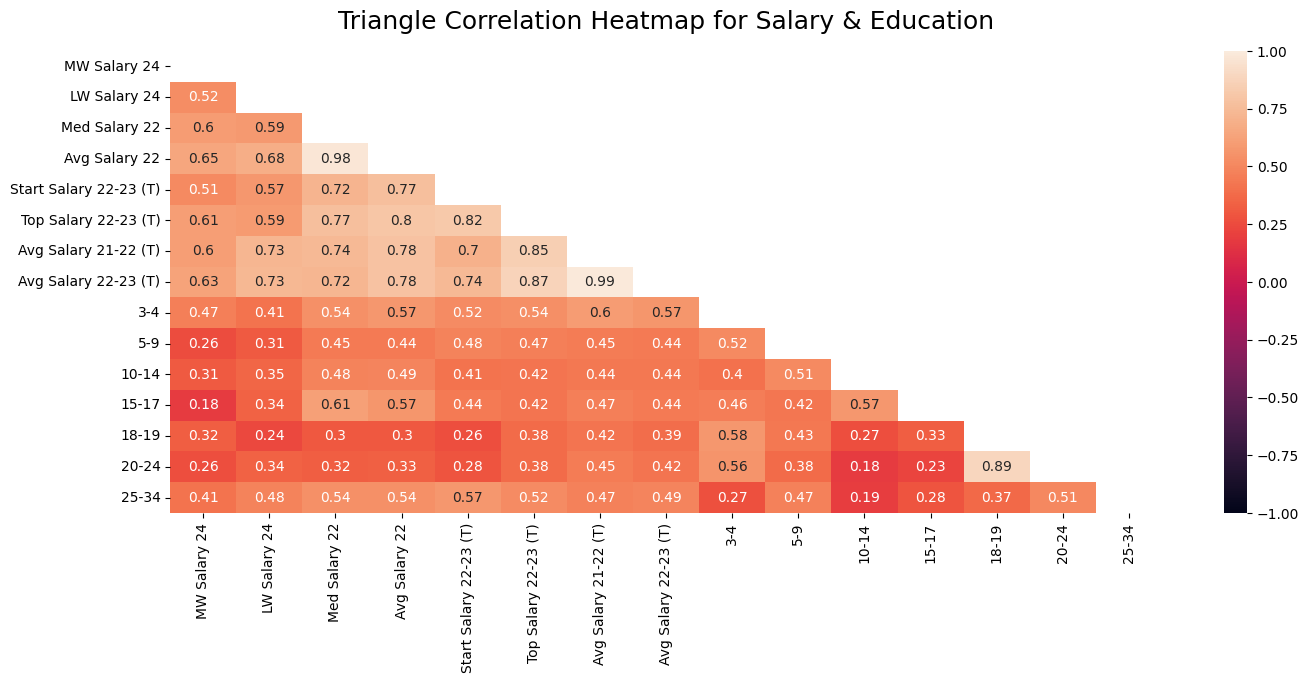

In [398]:
np.triu(np.ones_like(df_combined.corr()))
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_combined.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df_combined.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap for Salary & Education', fontdict={'fontsize':18}, pad=16);